In [1]:
import os

os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [2]:
import gc
import pickle
import sys

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf
from IPython.lib.display import Audio
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    f1_score,
    precision_score,
    recall_score,
    roc_curve,
)
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import Callback, ModelCheckpoint, TensorBoard
from tensorflow.keras.layers import (
    LSTM,
    Activation,
    BatchNormalization,
    Bidirectional,
    Conv1D,
    Dense,
    Dropout,
    Flatten,
    Input,
    MaxPool1D,
)

2024-05-21 09:58:37.297703: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-21 09:58:37.324021: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-21 09:58:37.324046: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-21 09:58:37.324630: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-05-21 09:58:37.328669: I tensorflow/core/platform/cpu_feature_guar

In [3]:
gpus = tf.config.list_physical_devices("GPU")
print(gpus)
tf.config.set_logical_device_configuration(
    gpus[0],
    [tf.config.LogicalDeviceConfiguration(memory_limit=4000)],
)

2024-05-21 09:58:38.443202: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:274] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2024-05-21 09:58:38.443238: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:129] retrieving CUDA diagnostic information for host: fedora
2024-05-21 09:58:38.443242: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:136] hostname: fedora
2024-05-21 09:58:38.443357: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:159] libcuda reported version is: 550.78.0
2024-05-21 09:58:38.443368: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:163] kernel reported version is: 550.78.0
2024-05-21 09:58:38.443371: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:241] kernel version seems to match DSO: 550.78.0


[]


IndexError: list index out of range

In [ ]:
emotion_list = {
    0: "neutral",
    1: "calm",
    2: "happy",
    3: "sad",
    4: "angry",
    5: "fearful",
    6: "disgusted",
    7: "surprised",
}

In [ ]:
def plot_network_history(network_history):
    fig, axes = plt.subplots(1, 2, figsize=(18, 6))
    axes[0].plot(network_history.history["loss"], label="Training Loss")
    axes[0].plot(network_history.history["val_loss"], label="Validation Loss")
    axes[0].set_xlabel("Epoch")
    axes[0].set_ylabel("Loss")
    axes[0].legend()

    axes[1].plot(
        network_history.history["categorical_accuracy"],
        label="Training Categorical Accuracy",
    )
    axes[1].plot(
        network_history.history["val_categorical_accuracy"],
        label="Validation Categorical Accuracy",
    )
    axes[1].set_xlabel("Epoch")
    axes[1].set_ylabel("Accuracy")
    axes[1].legend()
    plt.show()

In [ ]:
log_dir = "runs/pure_lstm_og_data"
with open("./data/processed_data.pickle", "rb") as f:
    data = pickle.load(f)
X_train = data["X_train"]
X_test = data["X_test"]
Y_train = data["Y_train"]
Y_test = data["Y_test"]

In [ ]:
X_train.shape

In [ ]:
print(gc.collect())
K.clear_session()

num_classes = len(Y_test[0])
model = Sequential()

layers = [
    Input(shape=(X_train.shape[1], X_train.shape[2])),
    LSTM(1024),
    Dense(num_classes, activation="softmax"),
]

model = tf.keras.Sequential(layers)
model.compile(
    loss="categorical_crossentropy", optimizer="adam", metrics=["categorical_accuracy"]
)

model.summary()

In [9]:
es = keras.callbacks.EarlyStopping(
    monitor="val_categorical_accuracy",
    min_delta=0.00005,
    patience=15,
    restore_best_weights=True,
)
lr_scheduler = keras.callbacks.ReduceLROnPlateau(
    monitor="val_categorical_accuracy",
    factor=0.3,
    patience=7,
    min_lr=1e-7,
    verbose=1,
)
tensorboard_callback = TensorBoard(log_dir=log_dir, update_freq="epoch")


network_history = model.fit(
    X_train,
    Y_train,
    epochs=100,
    batch_size=64,
    validation_split=0.2,
    callbacks=[es, lr_scheduler, tensorboard_callback],
)

Epoch 1/100


2024-05-21 05:34:23.035028: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8907
2024-05-21 05:34:23.113443: I external/local_xla/xla/service/service.cc:168] XLA service 0x7fd7ef6479c0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-05-21 05:34:23.113473: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce GTX 1650 with Max-Q Design, Compute Capability 7.5
2024-05-21 05:34:23.117098: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1716262463.189108   14017 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


150/150 [==============================] - 9s 54ms/step - loss: 1.9705 - categorical_accuracy: 0.2241 - val_loss: 1.8569 - val_categorical_accuracy: 0.2887 - lr: 0.0010
Epoch 2/100
150/150 [==============================] - 8s 52ms/step - loss: 1.8589 - categorical_accuracy: 0.2751 - val_loss: 1.7699 - val_categorical_accuracy: 0.3121 - lr: 0.0010
Epoch 3/100
150/150 [==============================] - 8s 52ms/step - loss: 1.7623 - categorical_accuracy: 0.3198 - val_loss: 1.7108 - val_categorical_accuracy: 0.3283 - lr: 0.0010
Epoch 4/100
150/150 [==============================] - 8s 52ms/step - loss: 1.6862 - categorical_accuracy: 0.3510 - val_loss: 1.6333 - val_categorical_accuracy: 0.3771 - lr: 0.0010
Epoch 5/100
150/150 [==============================] - 8s 52ms/step - loss: 1.6132 - categorical_accuracy: 0.3814 - val_loss: 1.6153 - val_categorical_accuracy: 0.3850 - lr: 0.0010
Epoch 6/100
150/150 [==============================] - 8s 52ms/step - loss: 1.5635 - categorical_accuracy: 

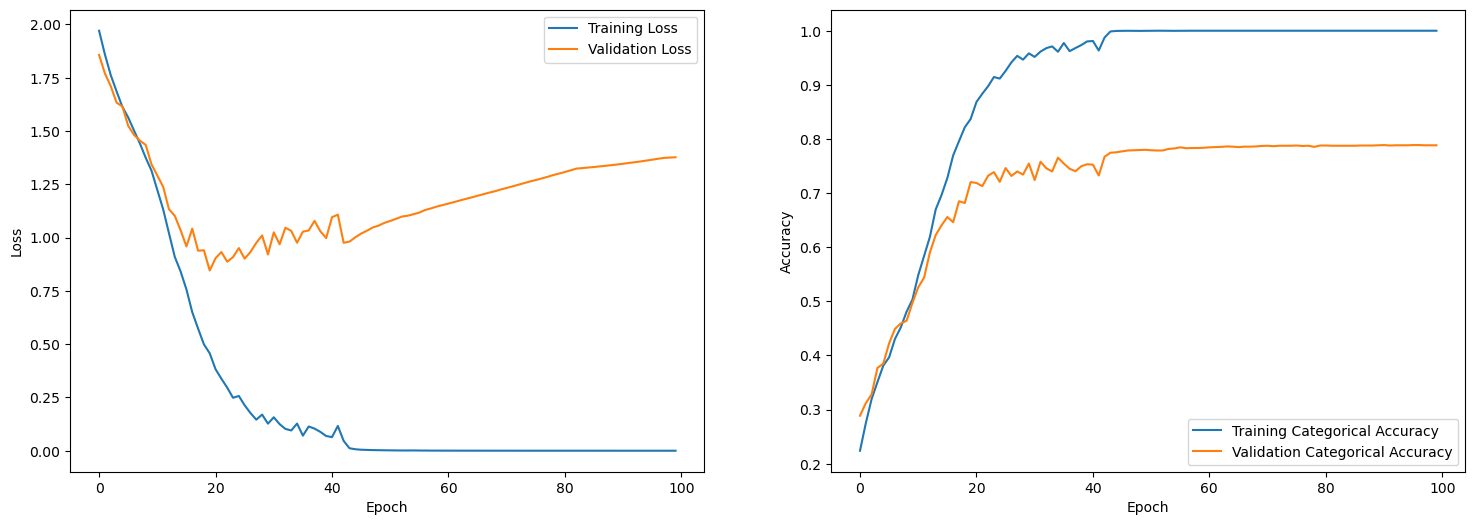

In [10]:
plot_network_history(network_history)

In [11]:
test_loss, test_acc = model.evaluate(X_test, Y_test)
preds = model.predict(X_test)

9/9 [==============================] - 0s 13ms/step


In [12]:
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, 1)
y_true = np.argmax(Y_test, 1)

print("Test accuracy: %g" % (accuracy_score(y_true, y_pred)))
print("Precision", precision_score(y_true, y_pred, average="macro"))
print("Recall", recall_score(y_true, y_pred, average="macro"))
print("f1_score", f1_score(y_true, y_pred, average="macro"))

9/9 [==============================] - 0s 13ms/step
Test accuracy: 0.513889
Precision 0.5012380047769329
Recall 0.5005325298768988
f1_score 0.49958696017101734


In [13]:
print(
    classification_report(y_true, y_pred, target_names=emotion_list.values(), digits=4)
)

              precision    recall  f1-score   support

     neutral     0.3500    0.3684    0.3590        19
        calm     0.6522    0.7317    0.6897        41
       happy     0.4000    0.4444    0.4211        36
         sad     0.4857    0.4359    0.4595        39
       angry     0.6970    0.6216    0.6571        37
     fearful     0.3714    0.4062    0.3881        32
   disgusted     0.4722    0.4857    0.4789        35
   surprised     0.5814    0.5102    0.5435        49

    accuracy                         0.5139       288
   macro avg     0.5012    0.5005    0.4996       288
weighted avg     0.5188    0.5139    0.5149       288



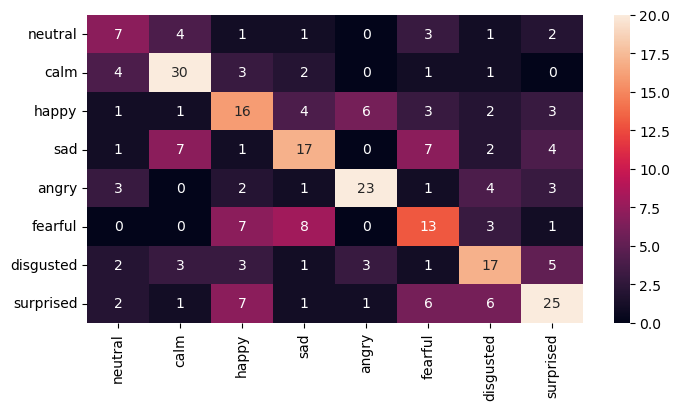

In [14]:
plt.figure(figsize=(8, 4))
conf = confusion_matrix(y_true, y_pred)
labels = emotion_list.values()
sns.heatmap(conf, annot=True, fmt="d", vmax=20, xticklabels=labels, yticklabels=labels)
plt.show()

In [4]:
model.save(f"./models/{log_dir.split('/')[-1]}.keras")

NameError: name 'model' is not defined